In [1]:
#We'll be using LSTM (Long Short-Term Memory network)- "type of recurrent neural network capable of remembering the past information and while predicting the future values, it takes this past information into account."
#april 1st 2013 to dec 31 2018

#Libraries and data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [107]:
#Read data
df=pd.read_csv('weather_train.csv')

In [103]:
#explore data
print(df.head())
df.shape

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [28]:
#We only care about the average temp
df = df.iloc[:, 3:4].values
print(df)

[[60]
 [57]
 [53]
 ...
 [48]
 [48]
 [39]]


In [29]:
#Data scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1)) #scale the data between 0 and 1
df_scaled = scaler.fit_transform(df)

c:\users\sagi\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [30]:
#predicting the avg temp based on the avg temp for the past 60 days
"the feature set should contain the temp values for the past 60 days"
"the label (dependent var.) should be the temp at the 61st day"
features_set = []
labels = []
for i in range(60, 2101): #the data has 2101 records
    features_set.append(df_scaled[i-60:i, 0]) #loop that starts from 61st record and stores all the previous 60 records to the feature_set list"
    labels.append(df_scaled[i, 0]) #the 61st record is stored in the labels list

features_set, labels = np.array(features_set), np.array(labels)  #convert to numpy array
#LSTM required a 3 dimension format so we'll convert ours
#first dimension is the number of records or rows (1511 here)
#second dimension is the number of time steps (60 here)
#third dimension is the number of indicators (we are only using 1 feature - open, so 1 indicator)

features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))

In [31]:
#Define the model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

model = Sequential() #the model class. We will add LSTM, Dropout and Dense layers to this model.

#Creating LSTM and Dropout Layers
model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set.shape[1], 1))) #use add() to add a layer
"The first parameter to the LSTM layer is the number of neurons or nodes that we want in the layer. The second parameter" \
" is return_sequences, which is set to true since we will add more layers to the model. The first parameter to the input_" \
"shape is the number of time steps while the last parameter is the number of indicators."

#Adding a dropout layer to our model (to avoid over-fitting)
model.add(Dropout(0.2))

#Adding three more LSTM and dropout layers to our model
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

#Creating Dense Layer
"To make our model more robust, we add a dense layer at the end of the model. The number of neurons in the dense layer" \
" will be set to 1 since we want to predict a single value in the output"
model.add(Dense(units = 1))

Using TensorFlow backend.


In [32]:
#Compile the LSTM
#adam optimizer to reduce the loss or to optimize the algorithm
model.compile(optimizer = 'adam', loss = 'mean_squared_error') #mean squared error as loss function

In [33]:
#Training
model.fit(features_set, labels, epochs = 100, batch_size = 32)

Epoch 1/100
2041/2041 [==============================] - 16s 8ms/step - loss: 0.0448
Epoch 2/100
2041/2041 [==============================] - 10s 5ms/step - loss: 0.0146
Epoch 3/100
2041/2041 [==============================] - 10s 5ms/step - loss: 0.0129
Epoch 4/100
2041/2041 [==============================] - 10s 5ms/step - loss: 0.0129
Epoch 5/100
2041/2041 [==============================] - 10s 5ms/step - loss: 0.0121
Epoch 6/100
2041/2041 [==============================] - 10s 5ms/step - loss: 0.0124
Epoch 7/100
2041/2041 [==============================] - 10s 5ms/step - loss: 0.0120
Epoch 8/100
2041/2041 [==============================] - 10s 5ms/step - loss: 0.0120
Epoch 9/100
2041/2041 [==============================] - 10s 5ms/step - loss: 0.0111
Epoch 10/100
2041/2041 [==============================] - 10s 5ms/step - loss: 0.0104
Epoch 11/100
2041/2041 [==============================] - 10s 5ms/step - loss: 0.0113
Epoch 12/100
2041/2041 [==============================] - 10s 5

In [104]:
#Testing
#Importing the testing data
df_test_complete = pd.read_csv('weather_test.csv')

In [105]:
#explore data
print(df_test_complete.head())
df_test_complete.shape

       STATION                                   NAME      DATE  TAVG
0  USW00024229  PORTLAND INTERNATIONAL AIRPORT, OR US  1/1/2019    35
1  USW00024229  PORTLAND INTERNATIONAL AIRPORT, OR US  1/2/2019    35
2  USW00024229  PORTLAND INTERNATIONAL AIRPORT, OR US  1/3/2019    47
3  USW00024229  PORTLAND INTERNATIONAL AIRPORT, OR US  1/4/2019    50
4  USW00024229  PORTLAND INTERNATIONAL AIRPORT, OR US  1/5/2019    44


(27, 4)

In [106]:
#preprocess
df_test_processed = df_test_complete.iloc[:, 3:4].values

In [108]:
#Converting Test Data to Right Format
df_total = pd.concat((df['TAVG'], df_test_complete['TAVG']), axis=0)
test_inputs = df_total[len(df_total) - len(df_test_complete) - 60:].values

In [109]:
#Scaling
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

In [110]:
#Prepating the testing data
test_features = []
for i in range(60, 80):
    test_features.append(test_inputs[i-60:i, 0])

In [111]:
#Convert to 3 dimensions
#first dimension is the number of records or rows (27 here)
#second dimension is the number of time steps (60 here)
#third dimension is the number of indicators (we are only using 1 feature - open, so 1 indicator)
test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

In [112]:
#Predictions
predictions = model.predict(test_features)
"Since we scaled our data, the predictions made by the LSTM are also scaled. We need to reverse the scaled prediction back to their actual values."
predictions = scaler.inverse_transform(predictions)

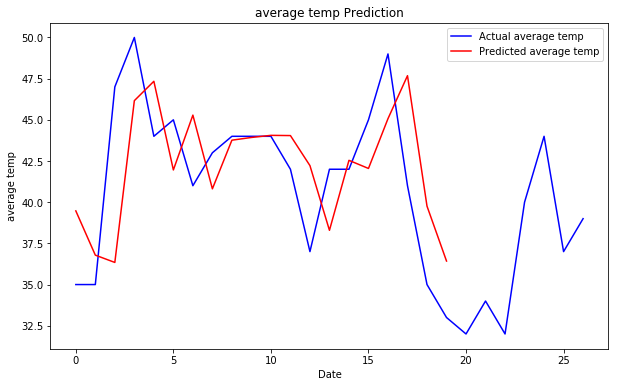

In [122]:
#Plotting
plt.figure(figsize=(10,6))
plt.plot(df_test_processed, color='blue', label='Actual average temp')
plt.plot(predictions , color='red', label='Predicted average temp')

plt.title('average temp Prediction')
plt.xlabel('Date')
plt.ylabel('average temp')
plt.legend()
plt.show()